# imports

In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import random_split
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import v2
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision
from torch.utils.data import DataLoader, Dataset, Subset
from torch import flatten, optim
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score,f1_score
from PIL import Image
from tqdm import tqdm
import time

import time


In [2]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()


In [29]:
BATCH_SIZE = 17
SHUFFLE = True
LEARNING_RATE = 0.001
EPOCHS = 30

CUDA = True
if CUDA and torch.cuda.is_available():
    device = "cuda"
else: device = "cpu"
print("device is:",device)

device is: cuda


# Functions

In [4]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def labelcounter(dataloader):
    pos,neg = 0,0
    for pic, label in dataloader:
        label_values = label.tolist()
        for label_value in label_values:
            if label_value == 0:
                neg += 1
            else:
                pos += 1
    return pos,neg
def test_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        test_loss = 0.0
        correct = 0
        total = 0
        all_predictions = []
        all_targets = []

        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            labels = torch.nn.functional.one_hot(labels.to(torch.int64), 2)
            labels = labels.to(torch.float)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            # _, predicted = torch.argmax(outputs.data, 1)
            # predicted = (outputs > 0.5).float()
            predicted = torch.argmax(outputs,dim=1)
            labels = torch.argmax(labels, dim=1)
            total += labels.size(0)
            # print("-")
            # print(predicted == labels)
            # print("-")
            # print(predicted)
            # print(labels)
            correct += (predicted == labels).sum().item()
            # print(torch.argmax(predicted.cpu(),dim=1).shape)
            # print(predicted.cpu())
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend((labels.cpu()).numpy())

        test_loss /= len(test_loader.dataset)
        accuracy = 100 * correct / total
        
        # Calculate confusion matrix
        
        print(len(all_predictions))
        print(len(all_targets))
        conf_matrix = confusion_matrix(all_targets, all_predictions)
        print(conf_matrix)
        # Calculate additional metrics
        precision = precision_score(all_targets, all_predictions, average='weighted')
        recall = recall_score(all_targets, all_predictions, average='weighted')
        f1 = f1_score(all_targets, all_predictions, average='weighted')

    return test_loss, accuracy, precision, recall, f1, conf_matrix

def make_weights_for_balanced_classes(images, nclasses):
    n_images = len(images)
    count_per_class = [0] * nclasses
    for _, image_class in images:
        count_per_class[image_class] += 1
    weight_per_class = [0.] * nclasses
    for i in range(nclasses):
        weight_per_class[i] = float(n_images) / float(count_per_class[i])
    weights = [0] * n_images
    for idx, (image, image_class) in enumerate(images):
        weights[idx] = weight_per_class[image_class]
    return weights

# Dataset

In [34]:
TRAIN_DATA_DIR = r"chest_xray\train"
TRAIN3_DATA_DIR = r"chest_xray\train2"
TRAIN2_DATA_DIR = r"chest_xray\train3"
VAL_DATA_DIR = r"chest_xray\val"
VAL2_DATA_DIR = r"chest_xray\val2"
TEST_DATA_DIR = r"chest_xray\test"

In [6]:
transform = transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=(0.8,1.2)),
        # transforms.Grayscale(),
        transforms.RandomAffine(degrees=(-15,15),shear=(0.2)),
        transforms.ToTensor()
        # transforms.Normalize(mean=[0],std=[1])
        # transforms.Normalize(mean=[0.485, 0.456, 0.406],
        #                     std=[0.229, 0.224, 0.225])
    ])

transform2 = transforms.Compose([
        transforms.Resize(size=(224,224)),
        # transforms.Grayscale(),
        transforms.ToTensor()
        # transforms.Normalize(mean=[0],std=[1])
        # transforms.Normalize(mean=[0.485, 0.456, 0.406],
        #                     std=[0.229, 0.224, 0.225])
    ])
# transform = v2.Compose([
#         v2.Resize(size=(224,224)),
#         v2.RandomHorizontalFlip(p=0.5),
#         v2.ToTensor(),
#         v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
#         v2.Normalize(mean=[0.485, 0.456, 0.406],
#                             std=[0.229, 0.224, 0.225])
#     ])
# Load dataset
train_set = datasets.ImageFolder(root=TRAIN_DATA_DIR, transform=transform)
val_set = datasets.ImageFolder(root=VAL_DATA_DIR,transform=transform2)
val2_set = datasets.ImageFolder(root=VAL2_DATA_DIR,transform=transform2)
test_set = datasets.ImageFolder(root=TEST_DATA_DIR,transform=transform2)
train_set_2 = datasets.ImageFolder(root=TRAIN2_DATA_DIR, transform=transform)
train_set_3 = datasets.ImageFolder(root=TRAIN3_DATA_DIR, transform=transform)

# Create data loaders for train, validation, and test sets
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)
train_loader_3 = DataLoader(train_set_3, batch_size=BATCH_SIZE, shuffle=True)
train_loader_2 = DataLoader(train_set_2, batch_size=BATCH_SIZE, shuffle=True)
val_loader_2 = DataLoader(val2_set, batch_size=BATCH_SIZE, shuffle=True)

transToPIL = v2.ToPILImage()
img = transToPIL(train_set_2[0][0])
img.show()


# print("train set size:",len(train_set))
# print("val set size:",len(val_set))
# print("test set size:",len(test_set))



In [7]:
# train_pos,train_neg = labelcounter(train_loader)
# val_pos,val_neg = labelcounter(val_loader)
# test_pos,test_neg = labelcounter(test_loader)

# species = ('train', 'val', 'test')
# balance = {
#     'positive': np.array([train_pos, val_pos, test_pos]),
#     'negative': np.array([train_neg, val_neg, test_neg]),
# }
# width = 0.7  # the width of the bars: can also be len(x) sequence


# fig, ax = plt.subplots()
# bottom = np.zeros(3)

# for positive, negative in balance.items():
#     p = ax.bar(species, negative, width, label=positive, bottom=bottom)
#     bottom += negative

#     ax.bar_label(p, label_type='center')

# ax.set_title('Dataset balance')
# ax.legend()

# plt.show()

In [32]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    best_val_loss = 1000
    best_model = model
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = torch.nn.functional.one_hot(labels.to(torch.int64), 2)
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.to(torch.float)
            loss = criterion(outputs, labels)
            loss = loss.to(device)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            if i % 100 == 0:
                print(f'Loss: {loss.item():.4f}')
        
        train_loss /= len(train_loader.dataset)
        writer.add_scalar("loss/train", train_loss, epoch)
        # print("loss:", loss.item())
    
        # Validation
        model.eval()
        val_loss = 0.0
        val_sum = 0
        val_tot = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels = torch.nn.functional.one_hot(labels.to(torch.int64), 2)
                labels = labels.to(torch.float)
                outputs = model(inputs)
                
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                val_tot += outputs.size(0)
                val_sum += torch.sum(torch.argmax(outputs,dim=1) == torch.argmax(labels,dim=1)).detach()
        
        val_loss /= len(val_loader.dataset)
        
        

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_sum/val_tot:.4f}')
        
        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
    return best_model


# Models

In [33]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = torchvision.models.resnet101(pretrained=True)
        modules = list(self.resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        self.dem_red1 = nn.Conv2d(2048, 1024, kernel_size=1, padding=0)
        self.dem_red2 = nn.Conv2d(1024, 512, kernel_size=1, padding=0)
        self.fc1 = nn.Linear(512*7*7,1000)
        self.act = nn.ReLU()
        self.act2 = nn.Softmax()
        self.fc2 = nn.Linear(1000,2)

    def forward(self,x):
        x = self.resnet(x)
        x = self.act(x)
        x = self.dem_red1(x)
        x = self.act(x)
        x = self.dem_red2(x)
        x = self.act(x)
        x = torch.flatten(x,start_dim=1)
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act2(x)

        return x

In [10]:
class wtf(nn.Module):
    def __init__(self):
        super().__init__()

        self.RELU = nn.ReLU()
        self.Tan = nn.Tanh()

        self.densenet = torchvision.models.densenet.DenseNet()
        
        # input: 32x32x1
        self.c1 = nn.Conv2d(1, 3, kernel_size=3, padding=1) # output: 32x32x3 SAME
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 16x16x3 
        self.c2 = nn.Conv2d(3, 6, kernel_size=3, padding=1) # output: 16x16x6 SAME
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 8x8x6 
        self.c3 = nn.Conv2d(6, 12, kernel_size=3, padding=1) # output: 8x8x12 SAME
        
        self.fc1 = nn.Linear(in_features=8*8*12, out_features=60) 

        self.logSoftmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        #Conv Layer 1
        x = self.c1(x)
        x = self.act(x)
        x = self.pool1(x)
        #Conv Layer 2        
        x = self.c2(x)
        x = self.act(x)
        x = self.pool2(x)
        #Conv Layer 3
        x = self.c3(x)
        x = self.act(x)
        #Flattening
        x = torch.flatten(x, 1)
        #FC Layer 1
        x = self.fc1(x)
        x = self.act(x)
        #FC Layer 2
        x = self.fc2(x)    
        #Softmax
        out = self.logSoftmax(x)

        return out

In [35]:
class TransferLearning(nn.Module):
    def __init__(self, my_pretrained_model):
        super(TransferLearning, self).__init__()
        # self.tjena = nn.Conv2d(1,3,1)
        self.pretrained = my_pretrained_model

        self.my_new_layers = nn.Sequential( nn.Dropout(p=0.3),
                                            nn.Linear(1000, 256),
                                            nn.ReLU(),
                                            nn.Dropout(p=0.4),
                                            nn.Linear(256,16),
                                            nn.ReLU(),
                                            nn.Dropout(p = 0.3),
                                            nn.Linear(16, 2),
                                            nn.Softmax())

                                            # nn.Softmax()) # Binary classification?
    
    def forward(self, x):
        # x = self.tjena(x)
        x = self.pretrained(x)
        x = self.my_new_layers(x)
        return x

Epoch 1/20:   0%|          | 0/304 [00:00<?, ?it/s]c:\Users\ludvi\anaconda3\envs\Jaha\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Epoch 1/20:   0%|          | 1/304 [00:00<02:38,  1.91it/s]

Loss: 1.6325


Epoch 1/20:  33%|███▎      | 101/304 [00:38<01:16,  2.64it/s]

Loss: 1.0489


Epoch 1/20:  66%|██████▌   | 201/304 [01:15<00:38,  2.69it/s]

Loss: 0.9287


Epoch 1/20:  99%|█████████▉| 301/304 [01:53<00:01,  2.67it/s]

Loss: 0.9647


Epoch 1/20: 100%|██████████| 304/304 [01:53<00:00,  2.67it/s]


Epoch 1/20, Train Loss: 1.0245, Val Loss: 1.1090, Val Accuracy: 0.5000


Epoch 2/20:   0%|          | 1/304 [00:00<02:27,  2.06it/s]

Loss: 1.1205


Epoch 2/20:  33%|███▎      | 101/304 [00:34<01:11,  2.85it/s]

Loss: 1.0246


Epoch 2/20:  66%|██████▌   | 201/304 [01:07<00:37,  2.77it/s]

Loss: 0.9549


Epoch 2/20:  99%|█████████▉| 301/304 [01:41<00:01,  2.97it/s]

Loss: 1.0008


Epoch 2/20: 100%|██████████| 304/304 [01:41<00:00,  2.98it/s]


Epoch 2/20, Train Loss: 1.0097, Val Loss: 1.1090, Val Accuracy: 0.5000


Epoch 3/20:   0%|          | 1/304 [00:00<01:18,  3.88it/s]

Loss: 0.9048


Epoch 3/20:  33%|███▎      | 101/304 [00:34<01:07,  3.02it/s]

Loss: 0.9991


Epoch 3/20:  66%|██████▌   | 201/304 [01:07<00:32,  3.21it/s]

Loss: 1.0489


Epoch 3/20:  99%|█████████▉| 301/304 [01:39<00:00,  3.05it/s]

Loss: 1.0009


Epoch 3/20: 100%|██████████| 304/304 [01:40<00:00,  3.02it/s]


Epoch 3/20, Train Loss: 1.0097, Val Loss: 1.1090, Val Accuracy: 0.5000


Epoch 4/20:   0%|          | 1/304 [00:00<02:13,  2.27it/s]

Loss: 1.0008


Epoch 4/20:  33%|███▎      | 101/304 [00:32<01:06,  3.04it/s]

Loss: 1.0649


Epoch 4/20:  66%|██████▌   | 201/304 [01:05<00:34,  3.02it/s]

Loss: 1.0729


Epoch 4/20:  99%|█████████▉| 301/304 [01:37<00:00,  3.15it/s]

Loss: 1.0970


Epoch 4/20: 100%|██████████| 304/304 [01:38<00:00,  3.09it/s]


Epoch 4/20, Train Loss: 1.0094, Val Loss: 1.1090, Val Accuracy: 0.5000


Epoch 5/20:   0%|          | 1/304 [00:00<01:53,  2.67it/s]

Loss: 1.0489


Epoch 5/20:  33%|███▎      | 101/304 [00:33<01:15,  2.69it/s]

Loss: 1.0729


Epoch 5/20:  66%|██████▌   | 201/304 [01:05<00:33,  3.09it/s]

Loss: 1.0011


Epoch 5/20:  99%|█████████▉| 301/304 [01:38<00:01,  2.96it/s]

Loss: 1.1210


Epoch 5/20: 100%|██████████| 304/304 [01:39<00:00,  3.07it/s]


Epoch 5/20, Train Loss: 1.0096, Val Loss: 1.1090, Val Accuracy: 0.5000


Epoch 6/20:   0%|          | 1/304 [00:00<01:54,  2.65it/s]

Loss: 1.0249


Epoch 6/20:  33%|███▎      | 101/304 [00:32<01:03,  3.20it/s]

Loss: 1.0729


Epoch 6/20:  66%|██████▌   | 201/304 [01:05<00:32,  3.15it/s]

Loss: 1.0008


Epoch 6/20:  99%|█████████▉| 301/304 [01:37<00:00,  3.29it/s]

Loss: 0.9768


Epoch 6/20: 100%|██████████| 304/304 [01:38<00:00,  3.09it/s]


Epoch 6/20, Train Loss: 1.0094, Val Loss: 1.1090, Val Accuracy: 0.5000


Epoch 7/20:   0%|          | 1/304 [00:00<01:42,  2.96it/s]

Loss: 1.0729


Epoch 7/20:  33%|███▎      | 101/304 [00:32<01:03,  3.21it/s]

Loss: 1.0012


Epoch 7/20:  66%|██████▌   | 201/304 [01:05<00:32,  3.14it/s]

Loss: 0.9768


Epoch 7/20:  99%|█████████▉| 301/304 [01:38<00:01,  2.89it/s]

Loss: 1.0489


Epoch 7/20: 100%|██████████| 304/304 [01:38<00:00,  3.08it/s]


Epoch 7/20, Train Loss: 1.0096, Val Loss: 1.1090, Val Accuracy: 0.5000


Epoch 8/20:   0%|          | 1/304 [00:00<01:26,  3.49it/s]

Loss: 0.9528


Epoch 8/20:  33%|███▎      | 101/304 [00:32<01:07,  3.02it/s]

Loss: 1.0485


Epoch 8/20:  66%|██████▌   | 201/304 [01:05<00:33,  3.10it/s]

Loss: 0.9297


Epoch 8/20:  99%|█████████▉| 301/304 [01:38<00:00,  3.08it/s]

Loss: 0.9669


Epoch 8/20: 100%|██████████| 304/304 [01:38<00:00,  3.08it/s]


Epoch 8/20, Train Loss: 1.0093, Val Loss: 1.1090, Val Accuracy: 0.5000


Epoch 9/20:   0%|          | 1/304 [00:00<01:47,  2.81it/s]

Loss: 1.0729


Epoch 9/20:  33%|███▎      | 101/304 [00:32<01:09,  2.93it/s]

Loss: 0.9768


Epoch 9/20:  66%|██████▌   | 201/304 [01:05<00:32,  3.16it/s]

Loss: 1.0249


Epoch 9/20:  99%|█████████▉| 301/304 [01:37<00:01,  2.99it/s]

Loss: 1.1259


Epoch 9/20: 100%|██████████| 304/304 [01:38<00:00,  3.09it/s]


Epoch 9/20, Train Loss: 1.0093, Val Loss: 1.1090, Val Accuracy: 0.5000


Epoch 10/20:   0%|          | 1/304 [00:00<01:51,  2.72it/s]

Loss: 1.0731


Epoch 10/20:  33%|███▎      | 101/304 [00:33<01:10,  2.89it/s]

Loss: 0.9528


Epoch 10/20:  66%|██████▌   | 201/304 [01:05<00:32,  3.17it/s]

Loss: 1.0249


Epoch 10/20:  99%|█████████▉| 301/304 [01:38<00:00,  3.20it/s]

Loss: 0.9323


Epoch 10/20: 100%|██████████| 304/304 [01:38<00:00,  3.07it/s]


Epoch 10/20, Train Loss: 1.0092, Val Loss: 1.1090, Val Accuracy: 0.5000


Epoch 11/20:   0%|          | 1/304 [00:00<01:46,  2.84it/s]

Loss: 0.9769


Epoch 11/20:  33%|███▎      | 101/304 [00:32<01:02,  3.24it/s]

Loss: 1.0009


Epoch 11/20:  66%|██████▌   | 201/304 [01:05<00:37,  2.72it/s]

Loss: 1.0251


Epoch 11/20:  99%|█████████▉| 301/304 [01:38<00:00,  3.00it/s]

Loss: 1.0489


Epoch 11/20: 100%|██████████| 304/304 [01:38<00:00,  3.07it/s]


Epoch 11/20, Train Loss: 1.0096, Val Loss: 1.1090, Val Accuracy: 0.5000


Epoch 12/20:   0%|          | 1/304 [00:00<01:54,  2.64it/s]

Loss: 1.0969


Epoch 12/20:  33%|███▎      | 101/304 [00:33<01:02,  3.26it/s]

Loss: 0.9842


Epoch 12/20:  66%|██████▌   | 201/304 [01:05<00:33,  3.10it/s]

Loss: 0.9529


Epoch 12/20:  99%|█████████▉| 301/304 [01:38<00:00,  3.11it/s]

Loss: 1.0489


Epoch 12/20: 100%|██████████| 304/304 [01:38<00:00,  3.08it/s]


Epoch 12/20, Train Loss: 1.0090, Val Loss: 1.1090, Val Accuracy: 0.5000


Epoch 13/20:   0%|          | 1/304 [00:00<01:57,  2.59it/s]

Loss: 1.0486


Epoch 13/20:  33%|███▎      | 101/304 [00:33<01:07,  3.01it/s]

Loss: 1.0730


Epoch 13/20:  66%|██████▌   | 201/304 [01:05<00:32,  3.13it/s]

Loss: 1.0250


Epoch 13/20:  99%|█████████▉| 301/304 [01:38<00:00,  3.18it/s]

Loss: 0.9288


Epoch 13/20: 100%|██████████| 304/304 [01:38<00:00,  3.08it/s]


Epoch 13/20, Train Loss: 1.0093, Val Loss: 1.1090, Val Accuracy: 0.5000


Epoch 14/20:   0%|          | 1/304 [00:00<01:34,  3.20it/s]

Loss: 1.0008


Epoch 14/20:  33%|███▎      | 101/304 [00:32<01:05,  3.11it/s]

Loss: 1.0695


Epoch 14/20:  66%|██████▌   | 201/304 [01:05<00:32,  3.19it/s]

Loss: 0.9768


Epoch 14/20:  99%|█████████▉| 301/304 [01:38<00:00,  3.13it/s]

Loss: 0.9288


Epoch 14/20: 100%|██████████| 304/304 [01:38<00:00,  3.07it/s]


Epoch 14/20, Train Loss: 1.0093, Val Loss: 1.1090, Val Accuracy: 0.5000


Epoch 15/20:   0%|          | 1/304 [00:00<01:40,  3.02it/s]

Loss: 1.0249


Epoch 15/20:  33%|███▎      | 101/304 [00:32<01:05,  3.10it/s]

Loss: 1.0809


Epoch 15/20:  66%|██████▌   | 201/304 [01:05<00:31,  3.31it/s]

Loss: 1.0008


Epoch 15/20:  99%|█████████▉| 301/304 [01:38<00:00,  3.18it/s]

Loss: 1.0018


Epoch 15/20: 100%|██████████| 304/304 [01:38<00:00,  3.08it/s]


Epoch 15/20, Train Loss: 1.0091, Val Loss: 1.1090, Val Accuracy: 0.5000


Epoch 16/20:   0%|          | 1/304 [00:00<01:33,  3.25it/s]

Loss: 1.0024


Epoch 16/20:  33%|███▎      | 101/304 [00:32<01:06,  3.05it/s]

Loss: 1.0248


Epoch 16/20:  66%|██████▌   | 201/304 [01:04<00:32,  3.17it/s]

Loss: 1.0009


Epoch 16/20:  99%|█████████▉| 301/304 [01:37<00:00,  3.11it/s]

Loss: 1.0489


Epoch 16/20: 100%|██████████| 304/304 [01:38<00:00,  3.08it/s]


Epoch 16/20, Train Loss: 1.0092, Val Loss: 1.1090, Val Accuracy: 0.5000


Epoch 17/20:   0%|          | 1/304 [00:00<01:21,  3.70it/s]

Loss: 0.9291


Epoch 17/20:  33%|███▎      | 101/304 [00:32<01:03,  3.21it/s]

Loss: 1.0729


Epoch 17/20:  66%|██████▌   | 201/304 [01:04<00:30,  3.40it/s]

Loss: 0.9287


Epoch 17/20:  99%|█████████▉| 301/304 [01:37<00:00,  3.07it/s]

Loss: 1.0249


Epoch 17/20: 100%|██████████| 304/304 [01:38<00:00,  3.08it/s]


Epoch 17/20, Train Loss: 1.0093, Val Loss: 1.1090, Val Accuracy: 0.5000


Epoch 18/20:   0%|          | 1/304 [00:00<01:44,  2.90it/s]

Loss: 1.0493


Epoch 18/20:  33%|███▎      | 101/304 [00:26<01:07,  3.01it/s]

Loss: 1.0974


Epoch 18/20:  66%|██████▌   | 201/304 [00:59<00:34,  3.01it/s]

Loss: 0.9528


Epoch 18/20:  99%|█████████▉| 301/304 [01:31<00:00,  3.03it/s]

Loss: 1.0008


Epoch 18/20: 100%|██████████| 304/304 [01:32<00:00,  3.29it/s]


Epoch 18/20, Train Loss: 1.0091, Val Loss: 1.1090, Val Accuracy: 0.5000


Epoch 19/20:   0%|          | 1/304 [00:00<01:37,  3.12it/s]

Loss: 1.0249


Epoch 19/20:  33%|███▎      | 101/304 [00:32<01:11,  2.85it/s]

Loss: 1.0731


Epoch 19/20:  66%|██████▌   | 201/304 [01:04<00:33,  3.03it/s]

Loss: 1.0249


Epoch 19/20:  99%|█████████▉| 301/304 [01:37<00:00,  3.10it/s]

Loss: 1.0489


Epoch 19/20: 100%|██████████| 304/304 [01:38<00:00,  3.08it/s]


Epoch 19/20, Train Loss: 1.0091, Val Loss: 1.1090, Val Accuracy: 0.5000


Epoch 20/20:   0%|          | 1/304 [00:00<01:41,  2.99it/s]

Loss: 1.0008


Epoch 20/20:  33%|███▎      | 101/304 [00:32<01:02,  3.25it/s]

Loss: 1.0008


Epoch 20/20:  66%|██████▌   | 201/304 [01:05<00:33,  3.05it/s]

Loss: 0.9770


Epoch 20/20:  99%|█████████▉| 301/304 [01:38<00:01,  2.89it/s]

Loss: 0.9768


Epoch 20/20: 100%|██████████| 304/304 [01:39<00:00,  3.07it/s]


Epoch 20/20, Train Loss: 1.0091, Val Loss: 1.1090, Val Accuracy: 0.5000
624
624
[[  0 234]
 [  0 390]]
Accuracy: 62.5
Precision: 0.390625
Recall: 0.625
F1-Score: 0.4807692307692308
Test Loss: 0.0627, Test Accuracy: 62.50%
Confusion matrix, without normalization


c:\Users\ludvi\anaconda3\envs\Jaha\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


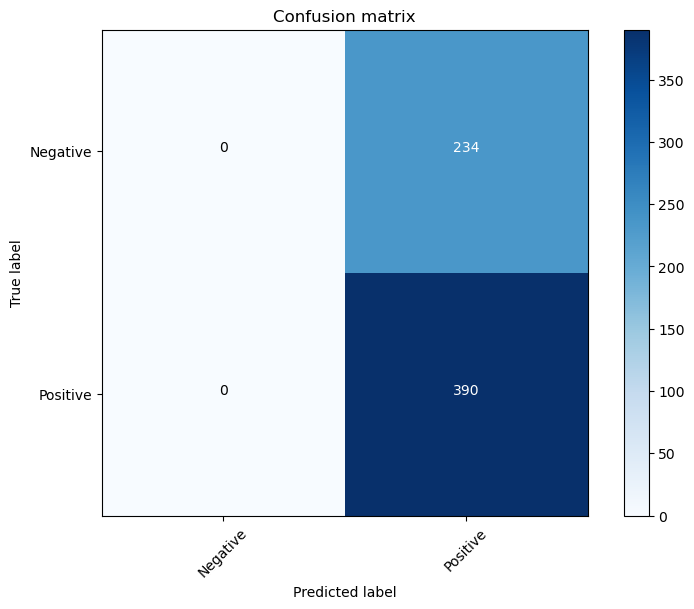

In [36]:
vgg = TransferLearning(torchvision.models.vgg19()).to(device)
optimizer = torch.optim.Adam(params=vgg.parameters(),lr=0.0001,weight_decay=0.01)
criterion = torch.nn.CrossEntropyLoss(weight = torch.tensor([1,2.888])).to(device)
trained_model1 = train_model(vgg,criterion,optimizer,train_loader_2,val_loader_2,num_epochs=EPOCHS)

# densenet1 = TransferLearning(torchvision.models.densenet.densenet121()).to(device)
# optimizer = torch.optim.Adam(params=densenet1.parameters(),lr=0.0001,weight_decay=0.025)
# criterion = torch.nn.CrossEntropyLoss(weight = torch.tensor([1,2.888])).to(device)
# trained_model1 = train_model(densenet1,criterion,optimizer,train_loader_2,val_loader_2,num_epochs=EPOCHS)


# resnet2 = TransferLearning(torchvision.models.resnet101(pretrained=True)).to(device)
# optimizer = torch.optim.Adam(params=resnet2.parameters(),lr=0.0001,weight_decay=0.025)
# criterion = torch.nn.CrossEntropyLoss(weight = torch.tensor([1,2.888])).to(device)



test_loss, accuracy, precision, recall, f1, conf_matrix = test_model(trained_model1, test_loader,criterion)

print("Accuracy:",accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:",f1)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
plt.figure(figsize=(8, 6))
plot_confusion_matrix(conf_matrix, classes=['Negative', 'Positive'], normalize=None)
plt.show()
writer.close()

Run 1: Resnet med aug

![alt text](image.png)